# Metropolis Hastings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Observations

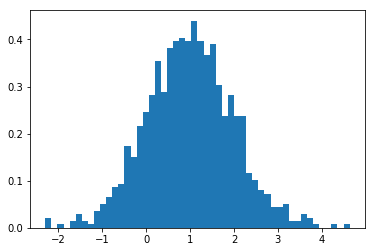

In [18]:
num_observations = 1000
theta_true = 1.


N = torch.distributions.normal.Normal(theta_true, 1.)
observations = N.sample(torch.Size([num_observations])).view(-1).numpy()

plt.hist(observations, bins=50, density=True)
plt.show()

## Posterior inference with Metropolis-Hastings

In [19]:
def log_likelihood(theta, observations):
    with torch.no_grad():
        N = torch.distributions.normal.Normal(theta.item(), 1.)
        likelihood = N.log_prob(observations).sum()
        
    return likelihood

In [20]:
from hypothesis.transition import NormalTransitionDistribution
from hypothesis.transition import UniformTransitionDistribution

transition = NormalTransitionDistribution(.1)

min = -5
max = 6
#transition = UniformTransitionDistribution(min, max)

In [21]:
from hypothesis.inference import MetropolisHastings

sampler = MetropolisHastings(log_likelihood, transition)

In [22]:
theta_0 = torch.tensor(5).float()
result = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=100000,
    burnin_steps=5000)

In [23]:
from hypothesis.visualization.mcmc import plot_trace
from hypothesis.visualization.mcmc import plot_autocorrelation

figure_height = 20
figure_width = 20

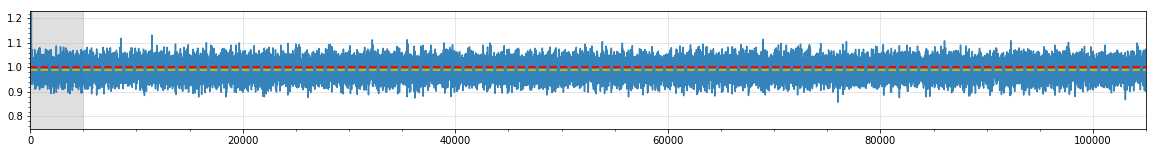

In [34]:
fig, axes = plot_trace(result, truth=theta_true, aspect=1, show_burnin=True, show_mean=True)
fig.set_figheight(figure_height)
fig.set_figwidth(figure_width)
plt.show()

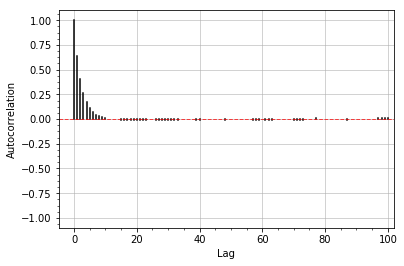

In [25]:
plot_autocorrelation(result, max_lag=100, interval=1)

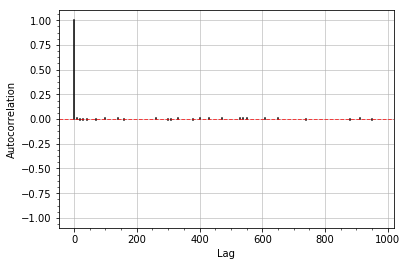

In [26]:
plot_autocorrelation(result, max_lag=1000, interval=10)

In [27]:
effective_size = result.effective_size()

effective_size

15336

In [28]:
result.efficiency()

0.15336

In [29]:
thinned_chain = result.thin()

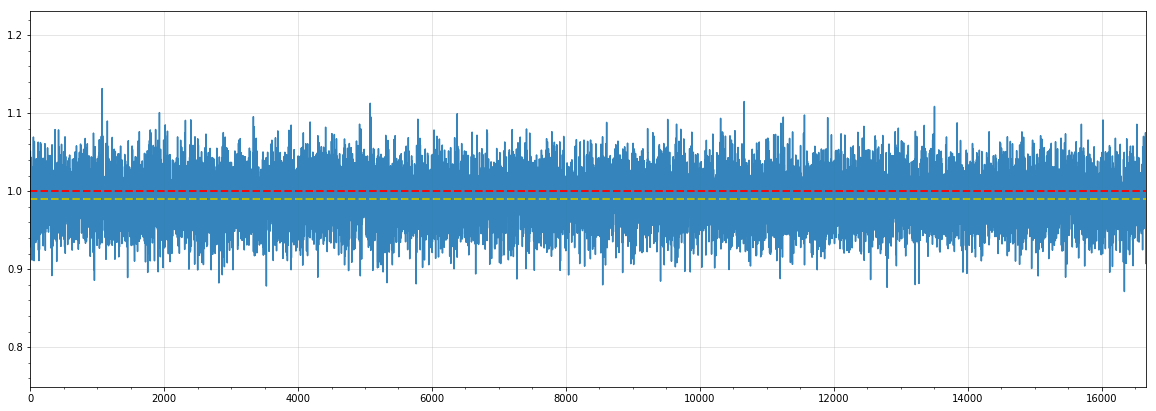

In [30]:
fig, axes = plot_trace(thinned_chain, truth=theta_true, aspect=5, show_burnin=True, show_mean=True)
fig.set_figheight(figure_height)
fig.set_figwidth(figure_width)
plt.show()

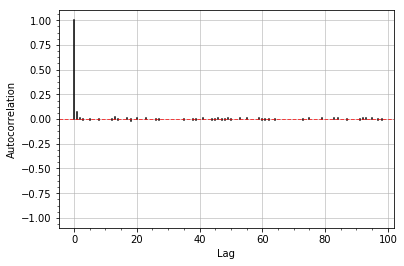

In [31]:
plot_autocorrelation(thinned_chain, max_lag=100, interval=1)

In [32]:
thinned_chain.effective_size()

5284

In [33]:
thinned_chain.efficiency()

0.3170336593268135